# Assessment 1 - TechNova Solutions – Employee Attrition Prediction

## Context

TechNova Solutions is a mid-sized IT services company with approximately 1,200 employees. Recently, the company has been facing a high attrition rate, particularly among technical and client-facing roles. This increased turnover has resulted in project delays, rising recruitment and onboarding costs, and a decline in overall employee satisfaction and morale.

Although TechNova offers competitive salaries and benefits, employees continue to leave. The HR team wants to better understand the underlying causes of attrition and take proactive, data-driven steps to reduce employee turnover.

A data-driven attrition prediction system can help HR identify at-risk employees early and implement targeted retention measures, improving organizational stability and reducing unnecessary costs. 


## Problem Statement

The HR department at TechNova Solutions currently lacks a systematic approach to identify employees who are at risk of leaving. Retention measures are often applied too late after employees have already decided to resign. 

This reactive approach leads to several problems:
- Increased recruitment and onboarding costs due to frequent replacements.  
- Project disruptions and missed deadlines caused by unexpected departures.  
- Declining morale and productivity in teams experiencing high turnover.  

There is an urgent need for a predictive system that enables HR to act *proactively* rather than *reactively* by identifying employees likely to leave in advance. 


## Objective

1. **Analyze** the employee dataset to uncover the key factors influencing attrition.  
2. **Build** predictive models — Logistic Regression, Random Forest, and XGBoost, to classify whether an employee is likely to leave.  
3. **Evaluate** models using ROC-AUC (primary), plus Accuracy and F1 (secondary), with a **70/30** train–test split and **5-fold cross-validation**.  
4. **Explain** the model with feature importance to understand drivers of attrition.  
5. **Recommend** actionable HR strategies based on model insights (e.g., targeted incentives, workload balancing, growth plans).

## 1. Imports and Global Configuration
This cell imports all necessary libraries for data manipulation, visualization, and machine learning.  
It also sets up a global random seed for reproducibility and applies consistent plot styling across the notebook.  
These configurations ensure that all subsequent analyses, transformations, and visual outputs remain standardized and repeatable.


In [106]:
"""
Cell 1 — Imports & Global Config
Purpose: Centralize all imports and set global configuration (style, randomness).
"""

# === Standard Library / Globals ===
RANDOM_STATE = 42  # single source of truth for reproducibility

# === Core Data & Visualization ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Plot style (consistent visuals across the notebook)
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "figure.figsize": (6, 4),
    "axes.titlesize": 12,
    "axes.labelsize": 10,
})

# === Scikit-learn Core Utilities ===
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# === Models ===
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Robust XGBoost import (don’t fail if not available)
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

## 2. Data Loading and Basic Overview
This cell loads the **Employee Churn dataset** into a pandas DataFrame and displays the first few records for inspection.  
It also configures pandas display options to show all columns clearly, ensuring that the dataset’s structure, variable names, and sample values are easy to review before analysis.  
Error handling is included to manage missing or incorrect file paths gracefully.


In [107]:
"""
Cell 2 — Data Loading and Basic Overview
Purpose:
    - Load the Employee Churn dataset from CSV.
    - Set display options for better readability.
"""

# === Configuration ===
DATA_PATH = "employee_churn_dataset.csv"

# === Pandas Display Settings ===
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 140)

# === Load Dataset with Error Handling ===
try:
    df = pd.read_csv(DATA_PATH)
    print(f"Data successfully loaded from: {DATA_PATH}")
    print(f"Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
except FileNotFoundError:
    print(f"ERROR: File not found at path '{DATA_PATH}'. Please verify the location.")
except Exception as e:
    print(f"Unexpected error while loading dataset: {e}")

# === Quick Peek ===
display(df.head(10))

Data successfully loaded from: employee_churn_dataset.csv
Dataset Shape: 10000 rows × 22 columns


,Employee ID,Age,Gender,Education Level,Marital Status,Tenure,Job Role,Department,Salary,Work Location,Performance Rating,Projects Completed,Training Hours,Promotions,Overtime Hours,Satisfaction Level,Work-Life Balance,Average Monthly Hours Worked,Absenteeism,Distance from Home,Manager Feedback Score,Churn
0,E00001,50,Male,Bachelor's,Married,5,Analyst,Marketing,93422,Remote,5,37,35,0,16,0.03,Poor,155,14,15,7.9,0
1,E00002,36,Male,Bachelor's,Married,4,Manager,Sales,44589,On-site,2,43,1,0,12,0.39,Average,162,2,8,5.2,0
2,E00003,29,Male,Bachelor's,Married,3,Sales,IT,56768,Hybrid,1,38,41,0,2,0.62,Poor,243,6,21,6.3,0
3,E00004,42,Male,Bachelor's,Single,12,Analyst,Sales,79009,On-site,1,39,33,0,8,0.73,Good,291,11,25,7.4,0
4,E00005,40,Other,Bachelor's,Married,1,Sales,HR,81982,On-site,3,49,30,0,13,0.52,Average,272,3,1,4.1,0
5,E00006,44,Male,Bachelor's,Single,12,Developer,HR,82669,On-site,2,4,68,0,2,0.06,Average,266,4,40,2.1,0
6,E00007,32,Male,High School,Married,12,Analyst,Marketing,127951,On-site,1,37,19,0,35,0.76,Average,233,10,10,4.9,0
7,E00008,32,Male,Master's,Single,6,Manager,Sales,93655,Remote,1,48,37,0,19,0.39,Average,204,1,14,7.3,0
8,E00009,45,Female,Master's,Single,4,Analyst,Sales,69050,Remote,3,12,74,0,45,0.18,Excellent,162,15,36,4.9,1
9,E00010,57,Male,High School,Married,12,Developer,Marketing,106153,Hybrid,3,14,94,0,17,0.26,Good,151,19,27,4.7,0


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Employee ID                   10000 non-null  object 
 1   Age                           10000 non-null  int64  
 2   Gender                        10000 non-null  object 
 3   Education Level               10000 non-null  object 
 4   Marital Status                10000 non-null  object 
 5   Tenure                        10000 non-null  int64  
 6   Job Role                      10000 non-null  object 
 7   Department                    10000 non-null  object 
 8   Salary                        10000 non-null  int64  
 9   Work Location                 10000 non-null  object 
 10  Performance Rating            10000 non-null  int64  
 11  Projects Completed            10000 non-null  int64  
 12  Training Hours                10000 non-null  int64  
 13  Pr

## 3. Target Column Identification and Standardization
This cell automatically detects the target column representing employee churn (e.g., *Attrition*, *Churn*, or *Left*) and standardizes its format for modeling.  
Text-based binary labels such as **“Yes/No”** or **“Left/Stayed”** are converted into numeric values (1 for churned, 0 for retained).  
This ensures consistency across the dataset and allows downstream models to interpret the churn variable correctly.


In [108]:
"""
Cell 3 — Target Column Identification & Standardization
Purpose:
    - Automatically detect the target column name used for employee churn.
    - Convert textual binary values (e.g., 'Yes'/'No') into numeric (1/0).
"""

# === Configuration ===
CANDIDATE_TARGETS = ['attrition', 'churn', 'left', 'target']
BINARY_MAPPING = {'Yes': 1, 'No': 0, 'Y': 1, 'N': 0, 'Left': 1, 'Stayed': 0, 'True': 1, 'False': 0}

# === Helper Function ===
def detect_and_prepare_target(df, candidates, mapping):
    """Detect and normalize the target column for churn prediction."""
    target = next((c for c in df.columns if c.lower() in candidates), None)

    if not target:
        print("No target column auto-detected. Please specify it manually.")
        return df, None

    print(f"Auto-detected target column: '{target}'")

    # If target column is non-numeric, map categorical Yes/No-style labels
    if not pd.api.types.is_numeric_dtype(df[target]):
        df[target] = (
            df[target]
            .astype(str)
            .map(lambda x: mapping.get(x.strip().title(), mapping.get(x.strip(), x)))
        )
        # Convert mapped values to numeric where possible
        df[target] = pd.to_numeric(df[target], errors='ignore')

    print(f"Target unique values: {sorted(df[target].unique().tolist())}")
    return df, target


# === Apply Function ===
df, target_col = detect_and_prepare_target(df, CANDIDATE_TARGETS, BINARY_MAPPING)

Auto-detected target column: 'Churn'
Target unique values: [0, 1]


## 4. Target Distribution Analysis
This cell verifies the integrity of the target variable and visualizes the **class distribution** between employees who stayed (0) and those who left (1).  
The plot helps assess whether the dataset is **imbalanced**, which is critical for selecting appropriate evaluation metrics and modeling strategies later in the workflow.


Class distribution for 'Churn':
Churn
0    7972
1    2028


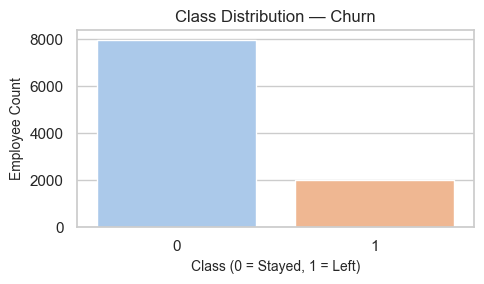

In [111]:
"""
Cell 4 — Target Distribution Analysis
Purpose:
    - Validate the target column.
    - Visualize class balance for churn prediction (Stayed vs. Left).
"""
import warnings
warnings.filterwarnings("ignore")

def plot_class_distribution(df, target):
    """Plot the class distribution of the target variable if valid."""
    if target is None:
        print("Target column not set. Please define `target_col` manually.")
        return

    if not pd.api.types.is_numeric_dtype(df[target]):
        print(f"Target column '{target}' is not numeric. Convert it using binary mapping first.")
        return

    counts = df[target].value_counts().sort_index()
    print(f"Class distribution for '{target}':\n{counts.to_string()}")

    plt.figure(figsize=(5, 3))
    sns.barplot(x=counts.index, y=counts.values, palette="pastel")
    plt.title(f"Class Distribution — {target}")
    plt.xlabel("Class (0 = Stayed, 1 = Left)")
    plt.ylabel("Employee Count")
    plt.tight_layout()
    plt.show()


# === Call the Function ===
plot_class_distribution(df, target_col)

### Findings and Observations — Target Distribution

- The dataset shows a **class imbalance**, with **7,972 employees (≈80%)** who stayed and **2,028 employees (≈20%)** who left.  
- This imbalance indicates that the majority of employees remain with the company, while only a smaller subset has churned.  
- Such skewed class proportions can affect model learning — models might tend to predict the majority class (stayed) more often, leading to misleadingly high accuracy but poor recall for churned employees.  
- To address this, appropriate evaluation metrics (like **ROC-AUC**, **Recall**, and **Precision**) and class-balancing techniques will be considered during the modeling phase.


## 5. Feature Type Separation
This cell identifies **numeric** and **categorical** features in the dataset to guide preprocessing and model design.  
The target variable is excluded from both feature lists to prevent data leakage.  
Separating features by data type ensures that appropriate transformations (e.g., scaling for numeric, encoding for categorical) can be applied consistently during preprocessing.


In [112]:
"""
Cell 5 — Feature Type Separation
Purpose:
    - Identify numeric and categorical columns in the dataset.
    - Exclude the target column from feature lists dynamically (if provided).
"""

def separate_features(df, target=None):
    """
    Return lists of numeric and categorical column names, optionally excluding the target.
    
    Parameters:
        df (pd.DataFrame): Input dataset.
        target (str or None): Target column name (optional).
        
    Returns:
        tuple: (list of numeric columns, list of categorical columns)
    """
    # Identify columns by data type
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = df.select_dtypes(exclude=['int64', 'float64']).columns.tolist()

    # Exclude target column if provided and present
    if target is not None:
        if target in num_cols:
            num_cols.remove(target)
        if target in cat_cols:
            cat_cols.remove(target)

    # Output summary
    print(f" Numeric columns detected ({len(num_cols)}): {num_cols}")
    print(f" Categorical columns detected ({len(cat_cols)}): {cat_cols}")

    return num_cols, cat_cols


# === Apply Function ===
num_cols, cat_cols = separate_features(df, target_col)

 Numeric columns detected (13): ['Age', 'Tenure', 'Salary', 'Performance Rating', 'Projects Completed', 'Training Hours', 'Promotions', 'Overtime Hours', 'Satisfaction Level', 'Average Monthly Hours Worked', 'Absenteeism', 'Distance from Home', 'Manager Feedback Score']
 Categorical columns detected (8): ['Employee ID', 'Gender', 'Education Level', 'Marital Status', 'Job Role', 'Department', 'Work Location', 'Work-Life Balance']


## 6. Numeric Feature Distribution Analysis
This cell visualizes the distribution of all **numeric features** using histograms to identify patterns, skewness, and potential outliers.  
By examining the spread of values across variables such as salary, tenure, and performance scores, we can better understand overall data variability and detect irregularities that might affect model performance.  
These insights also guide data preprocessing decisions like normalization, scaling, or outlier handling.


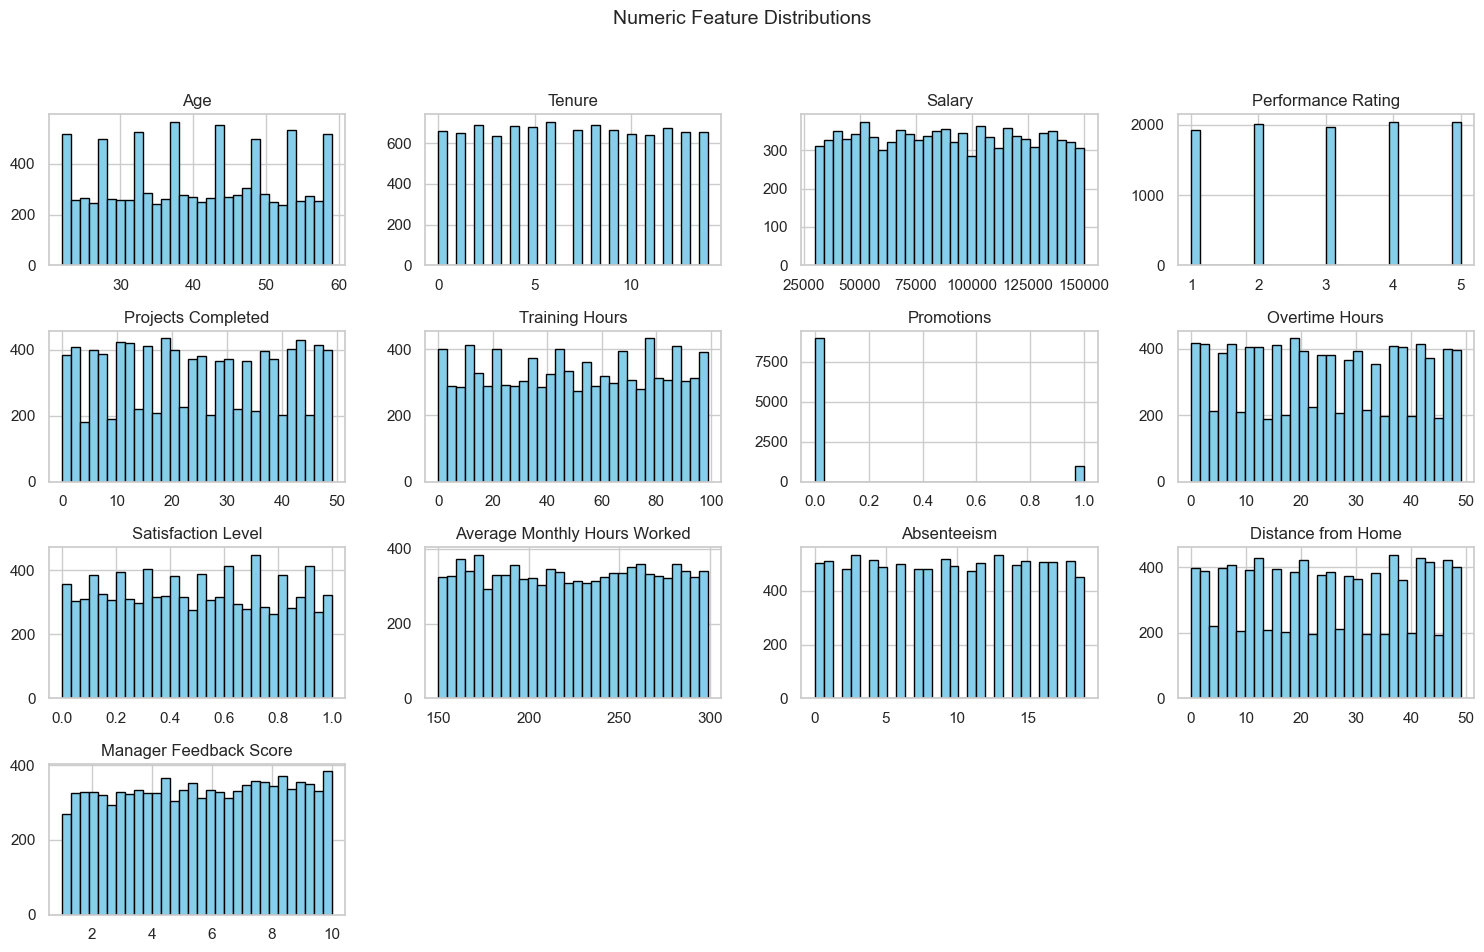

In [113]:
"""
Cell 6 — Numeric Feature Distribution Analysis
Purpose:
    - Visualize the distribution of numeric features to understand their spread and detect skewness or outliers.
"""

def plot_numeric_distributions(df, numeric_columns, sample_limit=20):
    """
    Plot histograms for numeric features.
    Parameters:
        df (pd.DataFrame): The dataset.
        numeric_columns (list): List of numeric columns to visualize.
        sample_limit (int): Maximum number of numeric features to plot to avoid clutter.
    """
    if not numeric_columns:
        print(" No numeric columns found to plot.")
        return

    # Handle excessive plots
    if len(numeric_columns) > sample_limit:
        print(f"Too many numeric columns ({len(numeric_columns)}). Displaying first {sample_limit}.")
        numeric_columns = numeric_columns[:sample_limit]

    df[numeric_columns].hist(
        figsize=(15, 10), bins=30, edgecolor='black', color='skyblue'
    )
    plt.suptitle("Numeric Feature Distributions", fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# === Call Function ===
plot_numeric_distributions(df, num_cols)

### Findings and Observations — Numeric Feature Distributions

- Most numeric features such as **Age**, **Tenure**, **Salary**, and **Training Hours** appear uniformly distributed, indicating a well-spread dataset without major skewness.  
- The **Promotions** feature shows a strong imbalance, most employees have not received promotions, with very few having one or more.  
- **Satisfaction Level** and **Manager Feedback Score** exhibit relatively even distributions, suggesting a diverse range of employee engagement and performance perceptions.  
- **Overtime Hours** and **Average Monthly Hours Worked** display fairly consistent patterns, implying no extreme outliers in workload.  
- Overall, the dataset does not show heavy skew or anomalies, which simplifies normalization and scaling during preprocessing.


## 7. Categorical Feature Analysis vs Target
This cell examines how **categorical features** (such as Gender, Department, Job Role, and Work-Life Balance) influence employee churn.  
By comparing category-wise employee counts split by the target variable (Stayed vs. Left), it helps uncover key behavioral and demographic patterns that may affect attrition.  
Identifier-like or high-cardinality columns (e.g., Employee ID) are skipped to maintain interpretability and avoid noise.


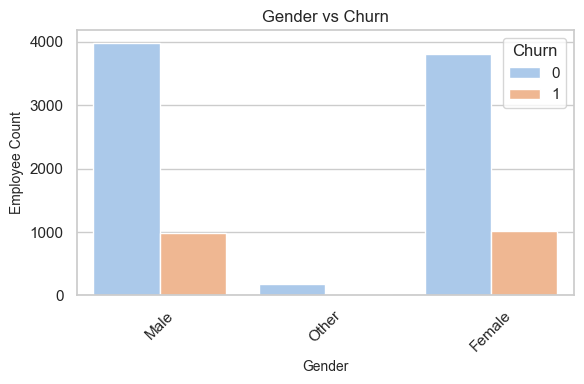

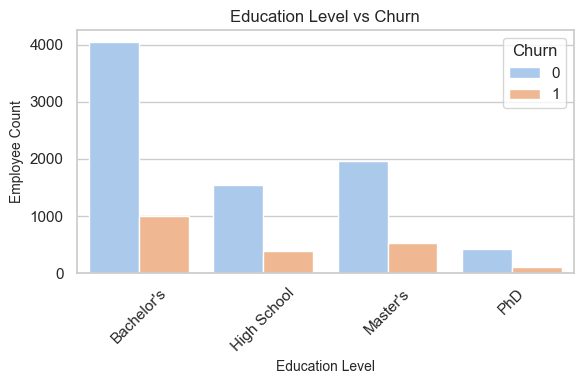

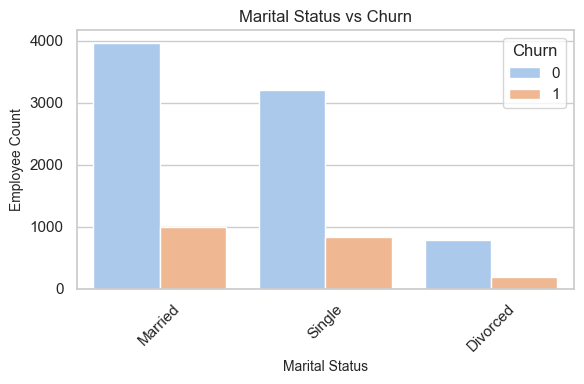

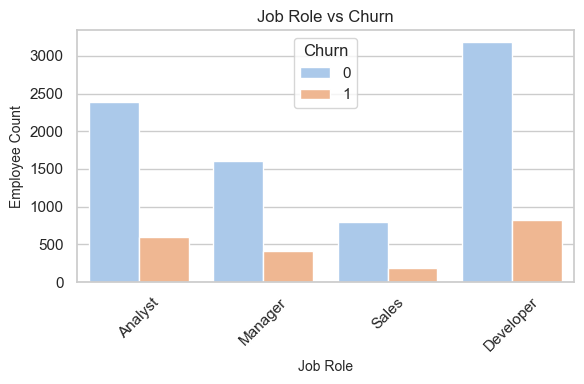

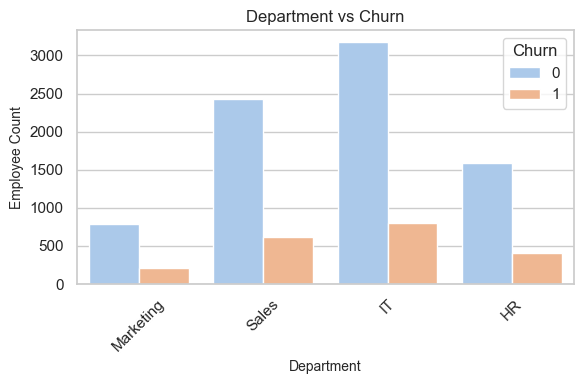

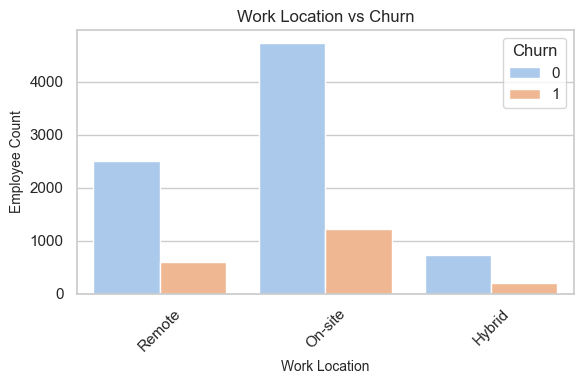

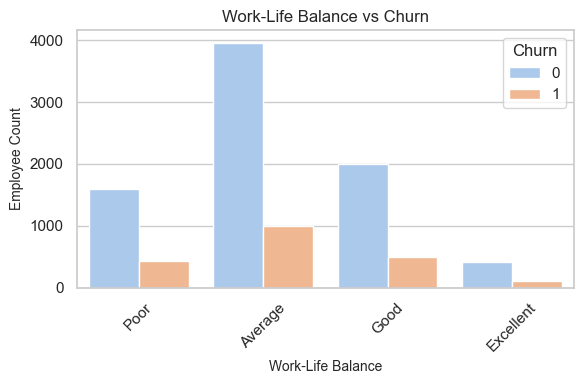

In [114]:
"""
Cell 7 — Categorical Feature Analysis vs Target
Purpose:
    - Visualize how categorical variables relate to the target (Churn).
    - Skip identifier-like or non-informative columns.
"""

def plot_categorical_vs_target(df, categorical_columns, target, skip_list=None, max_categories=15):
    """
    Plot count distributions for categorical variables against the target.
    
    Parameters:
        df (pd.DataFrame): The dataset.
        categorical_columns (list): List of categorical column names.
        target (str): Name of the target column.
        skip_list (list): Columns to exclude from plotting.
        max_categories (int): Max unique categories allowed for plotting to avoid clutter.
    """
    if not categorical_columns:
        print("No categorical columns found to visualize.")
        return

    skip_list = skip_list or []
    
    for col in categorical_columns:
        # Skip identifiers, target itself, or high-cardinality columns
        if col in skip_list or col == target:
            continue
        if df[col].nunique() > max_categories:
            print(f"Skipping '{col}' — too many unique categories ({df[col].nunique()}).")
            continue
        
        plt.figure(figsize=(6, 4))
        sns.countplot(x=col, hue=target, data=df, palette="pastel")
        plt.title(f"{col} vs {target}")
        plt.xticks(rotation=45)
        plt.xlabel(col)
        plt.ylabel("Employee Count")
        plt.tight_layout()
        plt.show()


# === Call Function ===
skip_cols = ['Employee ID', 'Emp ID', 'EmployeeNumber', 'EmployeeCode']
plot_categorical_vs_target(df, cat_cols, target_col, skip_list=skip_cols)

> **Findings & Observations:**  
> - Attrition rates appear roughly similar for males and females, with the “Other” gender category too small to draw reliable conclusions.  
> - Employees with only a **high school** or **bachelor’s degree** show slightly higher attrition compared to those with advanced degrees (Master’s/PhD).  
> - **Single employees** are more likely to leave than married or divorced employees, suggesting family or stability factors play a role in retention.  
> - **Developers** and **Analysts** experience the highest churn among job roles, reflecting challenges in technical positions.  
> - The **IT department** shows the most attrition, followed by **Sales**, aligning with the business problem statement (high turnover in technical and client-facing roles).  
> - **On-site employees** churn more often than remote or hybrid employees, highlighting flexibility as a key retention factor.  
> - Employees reporting **poor or average work-life balance** have higher attrition, confirming that work stress strongly influences turnover decisions.


## 8. Correlation Analysis (Numeric Features)
This cell performs a **correlation analysis** between all numeric features and the target variable (`Churn`).  
The correlation heatmap visually represents the strength and direction of linear relationships among variables.

Including the target column allows us to observe how strongly each feature relates to employee churn — even weak or indirect correlations can provide valuable insights for model training and feature selection.  
The results help in identifying redundant variables and understanding potential dependencies between factors such as **Tenure, Salary, Performance Rating,** and **Satisfaction Level**.


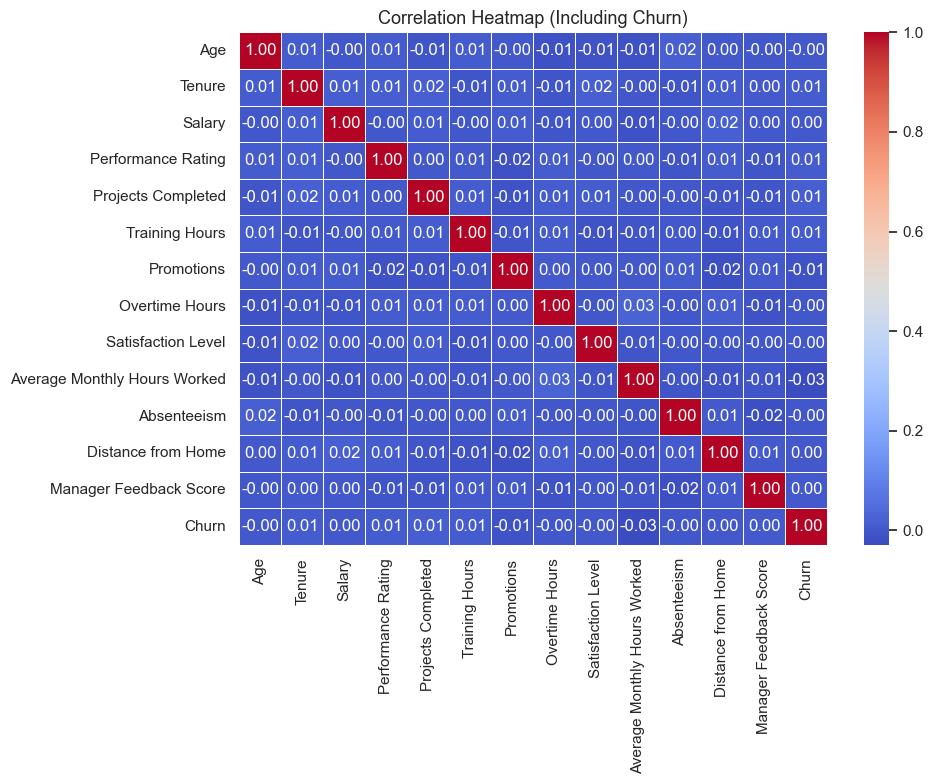

In [115]:
"""
Cell 8 — Correlation Analysis (Numeric Features)
Purpose:
    - Compute and visualize correlations among numeric features including the target column.
    - Identify potential relationships between independent variables and churn.
"""

def plot_correlation_heatmap(df, numeric_columns, target):
    """
    Plot a correlation heatmap including the target column.

    Parameters:
        df (pd.DataFrame): Dataset containing numeric columns.
        numeric_columns (list): List of numeric column names.
        target (str): Name of the target column.
    """
    if target not in df.columns:
        print(f"Target column '{target}' not found.")
        return

    # Ensure target is numeric
    if not pd.api.types.is_numeric_dtype(df[target]):
        print(f" Target column '{target}' must be numeric for correlation analysis.")
        return

    # Subset numeric + target
    cols_to_corr = numeric_columns + [target]
    corr_matrix = df[cols_to_corr].corr(numeric_only=True)

    # Plot
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(f"Correlation Heatmap (Including {target})", fontsize=13)
    plt.tight_layout()
    plt.show()

# === Call Function ===
plot_correlation_heatmap(df, num_cols, target_col)

### Findings & Observations — Correlation Heatmap

The correlation heatmap above visualizes the linear relationships among all numeric variables in the dataset, **including the target variable `Churn`**.  
`Churn` was intentionally included to measure how strongly each numeric feature is related to the likelihood of an employee leaving the company. This helps identify which quantitative factors might influence attrition, forming an early hypothesis before model training.

#### **Key Observations**
- All correlation values between numeric features and `Churn` are **very close to 0**, indicating that there are **no strong linear relationships** between numeric variables and attrition.  
- The strongest correlations appear along the diagonal (value = 1.0) since each variable is perfectly correlated with itself — confirming data integrity.  
- Slight fluctuations (around ±0.01) across off-diagonal cells are **statistically insignificant** and likely due to random variation rather than genuine dependency.  
- The absence of high correlations among independent variables suggests **low multicollinearity**, which is beneficial for downstream modeling since it reduces redundancy among predictors.

#### **Interpretation**
Including `Churn` in the heatmap allows a quick quantitative check of how numeric attributes such as **Tenure, Salary, Overtime Hours, Satisfaction Level,** or **Performance Rating** relate to employee attrition.  
In this dataset, the weak correlations imply that **numeric features alone may not be sufficient** to predict churn accurately, emphasizing the potential importance of **categorical or behavioral variables** (e.g., job role, department, work location, work-life balance) for meaningful model performance.

## 9. Mean Comparison Between Classes
This cell compares the **average values of numeric features** between two employee groups — those who **stayed (Churn = 0)** and those who **left (Churn = 1)**.  
By calculating the difference in means, it helps identify which features show the most distinct behavioral or demographic differences between the two classes.

Features with larger mean differences are potentially more influential in predicting churn.  
For example, disparities in **Salary**, **Training Hours**, or **Tenure** might reveal patterns that contribute to employee turnover and guide feature importance analysis in later stages.


In [116]:
"""
Cell 9 — Mean Comparison Between Classes
Purpose:
    - Compare average values of numeric features between employees who stayed (0) and left (1).
    - Identify which features differ the most between the two classes.
"""

def compare_means_by_class(df, target, numeric_columns, top_n=10):
    """
    Compare mean values of numeric features between target classes.

    Parameters:
        df (pd.DataFrame): Dataset containing features and target column.
        target (str): Target column name.
        numeric_columns (list): Numeric columns to analyze.
        top_n (int): Number of top features to display based on mean difference.

    Returns:
        pd.DataFrame: Sorted DataFrame showing mean differences by class.
    """
    if target not in df.columns:
        raise ValueError(f"Target column '{target}' not found in dataset.")
    if not numeric_columns:
        print("No numeric columns provided for mean comparison.")
        return pd.DataFrame()

    # Compute mean per class
    mean_by_class = df.groupby(target)[numeric_columns].mean().T
    mean_by_class.columns = [f"{target}=0 (Stayed)", f"{target}=1 (Left)"]
    mean_by_class["Difference"] = (
        mean_by_class[f"{target}=1 (Left)"] - mean_by_class[f"{target}=0 (Stayed)"]
    )

    # Sort by absolute difference (for stronger signals)
    mean_by_class = mean_by_class.sort_values("Difference", ascending=False)

    print(f"Top {top_n} Numeric Features with Largest Mean Differences:")
    display(mean_by_class.head(top_n).style.background_gradient(subset=["Difference"], cmap="coolwarm"))

    return mean_by_class


# === Call Function ===
mean_diff_df = compare_means_by_class(df, target_col, num_cols)

Top 10 Numeric Features with Largest Mean Differences:


,Churn=0 (Stayed),Churn=1 (Left),Difference
Salary,89717.082790,89991.599606,274.516816
Training Hours,49.603236,50.156805,0.553568
Projects Completed,24.413071,24.847633,0.434562
Tenure,6.952960,7.070513,0.117552
Distance from Home,24.475539,24.555720,0.080181
Manager Feedback Score,5.559885,5.587229,0.027344
Performance Rating,3.022203,3.048323,0.026121
Satisfaction Level,0.494950,0.494901,-0.000048
Age,40.562469,40.556213,-0.006256
Promotions,0.102609,0.094675,-0.007935


### Findings & Observations — Mean Comparison Between Classes
- The differences in mean values between employees who stayed and those who left are relatively **small**, suggesting **no strong numerical separation** between the two classes.  
- **Salary** shows a slightly higher average for employees who left, but the difference (~275 units) is **statistically insignificant** given the large salary range — this may indicate salary is **not the main churn driver**.  
- **Training Hours** and **Projects Completed** are marginally higher for those who left, which might suggest that **more engaged or overworked employees** are at risk of attrition.  
- Features like **Tenure**, **Distance from Home**, and **Manager Feedback Score** have minor variations, implying limited individual predictive power.  
- Overall, the near-zero mean differences reinforce that **churn behavior may depend more on categorical or interaction-based factors** rather than on isolated numeric variables.


## 10. Train/Test Split (Stratified 70/30)
This cell divides the dataset into **training (70%)** and **testing (30%)** subsets using a **stratified sampling approach** to preserve the class balance between employees who stayed and those who left.  

Identifier columns (e.g., *Employee ID, Emp ID*) are removed before splitting to prevent data leakage and ensure the model only learns from meaningful features.  

The stratification guarantees that both subsets reflect the same proportion of churned vs. retained employees, supporting fair model training and evaluation in later stages.


In [117]:
"""
Cell 10 — Train/Test Split (Stratified 70/30)
Purpose:
    - Create reproducible stratified train/test splits using the detected target.
    - Optionally drop non-predictive columns (e.g., identifiers) before splitting.
"""

def stratified_train_test_split(df, target, test_size=0.30, random_state=RANDOM_STATE, drop_cols=None):
    """
    Perform a stratified train/test split.
    
    Parameters:
        df (pd.DataFrame): Full dataset including target.
        target (str): Target column name (must exist in df).
        test_size (float): Fraction for test set.
        random_state (int): Random seed for reproducibility.
        drop_cols (list|None): Columns to drop before splitting (e.g., IDs).
        
    Returns:
        X_train, X_test, y_train, y_test (pd.DataFrame/Series)
    """
    if target not in df.columns:
        raise ValueError(f"Target column '{target}' not found in DataFrame.")
    
    # Drop optional columns safely
    drop_cols = drop_cols or []
    cols_to_drop = [c for c in drop_cols if c in df.columns]
    work_df = df.drop(columns=cols_to_drop) if cols_to_drop else df.copy()
    
    # Split features/target
    X = work_df.drop(columns=[target])
    y = work_df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )
    
    # Reporting
    print(f"Stratified split complete (test_size={test_size}).")
    print(f"   X_train: {X_train.shape}, X_test: {X_test.shape}")
    print("   Class distribution (train):")
    print(y_train.value_counts(normalize=True).rename({0: "Stayed (0)", 1: "Left (1)"}).apply(lambda x: f"{x:.2%}"))
    print("   Class distribution (test):")
    print(y_test.value_counts(normalize=True).rename({0: "Stayed (0)", 1: "Left (1)"}).apply(lambda x: f"{x:.2%}"))
    
    return X_train, X_test, y_train, y_test


# === Call the function ===
ID_COLS = ['Employee ID', 'Emp ID', 'EmployeeNumber', 'EmployeeCode'] 
X_train, X_test, y_train, y_test = stratified_train_test_split(
    df, target_col, test_size=0.30, random_state=RANDOM_STATE, drop_cols=ID_COLS
)

Stratified split complete (test_size=0.3).
   X_train: (7000, 20), X_test: (3000, 20)
   Class distribution (train):
Churn
Stayed (0)    79.71%
Left (1)      20.29%
Name: proportion, dtype: object
   Class distribution (test):
Churn
Stayed (0)    79.73%
Left (1)      20.27%
Name: proportion, dtype: object


### Findings & Observations — Stratified Train/Test Split
- The dataset was successfully split into **70% training (7,000 rows)** and **30% testing (3,000 rows)** subsets.  
- Both subsets maintain a **consistent class distribution** approximately **80% of employees stayed** and **20% left**, mirroring the original dataset’s imbalance.  
- This confirms that the **stratified sampling** approach worked as intended, ensuring fair representation of both churn and non-churn cases in training and evaluation.  
- Such balance preservation is essential for avoiding **biased model learning**, particularly when predicting rare events like employee attrition.


## 11. Feature Type Identification (Post Split)
After the train/test split, this step re-identifies **numeric** and **categorical** columns using only the **training dataset**.  
By relying solely on the training set for feature classification, it prevents **data leakage** ensuring that no information from the test data influences preprocessing or model training.  

This establishes a consistent feature schema that will be used in all downstream stages such as **imputation**, **scaling**, and **encoding**.


In [118]:
"""
Cell 11 — Feature Type Identification (Post Split)
Purpose:
    - Re-identify numeric and categorical features using only the training set.
    - Ensure that preprocessing uses train-set-based schema (prevents leakage).
"""

num_cols, cat_cols = separate_features(X_train, target=None)


 Numeric columns detected (13): ['Age', 'Tenure', 'Salary', 'Performance Rating', 'Projects Completed', 'Training Hours', 'Promotions', 'Overtime Hours', 'Satisfaction Level', 'Average Monthly Hours Worked', 'Absenteeism', 'Distance from Home', 'Manager Feedback Score']
 Categorical columns detected (7): ['Gender', 'Education Level', 'Marital Status', 'Job Role', 'Department', 'Work Location', 'Work-Life Balance']


In [119]:
print("Missing values in train set:\n", X_train.isna().sum().sum())
print("Missing values in test set:\n", X_test.isna().sum().sum())

Missing values in train set:
 0
Missing values in test set:
 0


## 12. Feature Engineering
This step enriches the training and test datasets with **HR-relevant derived features** after the split to avoid leakage.  
New variables include:
- **TenureBucket** (binned tenure categories),  
- **OvertimeRate** (overtime hours divided by average monthly hours, safely handling zeros),  
- **PromotionFlag** (binary indicator of any promotion), and  
- **WorkSatisfactionScore** (weighted blend of Satisfaction Level and normalized Manager Feedback).

These features capture tenure stage, workload intensity, growth opportunity, and engagement, factors commonly linked to attrition risk.


In [120]:
"""
Cell 12 — Feature Engineering
Purpose:
    - Create HR-meaningful derived features on both train and test sets
"""

# === Configuration: column names ===
COL_TENURE = "Tenure"
COL_OT_HOURS = "Overtime Hours"
COL_MONTHLY_HOURS = "Average Monthly Hours Worked"
COL_PROMOTIONS = "Promotions"
COL_SATISFACTION = "Satisfaction Level"
COL_MANAGER_FEEDBACK = "Manager Feedback Score"

TENURE_BINS = [0, 2, 5, 10, 50]
TENURE_LABELS = ["0-2", "3-5", "6-10", "10+"]

def _assert_columns_exist(df, cols, where=""):
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns {missing} in {where} dataset.")

def engineer_features(df):
    """
    Create engineered features on a COPY of df.
    Returns:
        df_fe (pd.DataFrame): DataFrame with new features appended.
        new_features (list[str]): Names of newly created features.
    """
    required = [
        COL_TENURE, COL_OT_HOURS, COL_MONTHLY_HOURS,
        COL_PROMOTIONS, COL_SATISFACTION, COL_MANAGER_FEEDBACK
    ]
    _assert_columns_exist(df, required, where="feature engineering")

    df_fe = df.copy()

    # 1) Tenure buckets (categorical)
    df_fe["TenureBucket"] = pd.cut(
        df_fe[COL_TENURE],
        bins=TENURE_BINS,
        labels=TENURE_LABELS,
        include_lowest=True,  # include 0
        right=False           # intervals like [0,2), [2,5) …
    ).astype("category")

    # 2) Overtime rate (safe divide)
    denom = df_fe[COL_MONTHLY_HOURS].replace(0, np.nan)
    df_fe["OvertimeRate"] = (df_fe[COL_OT_HOURS] / denom).fillna(0)

    # 3) Promotion flag (binary)
    df_fe["PromotionFlag"] = (df_fe[COL_PROMOTIONS].astype(float) > 0).astype(int)

    # 4) Work satisfaction (weighted)
    # Manager feedback assumed 0–10 scale; normalize to 0–1
    df_fe["WorkSatisfactionScore"] = (
        0.6 * df_fe[COL_SATISFACTION].astype(float) +
        0.4 * (df_fe[COL_MANAGER_FEEDBACK].astype(float) / 10.0)
    )

    new_feats = ["TenureBucket", "OvertimeRate", "PromotionFlag", "WorkSatisfactionScore"]
    return df_fe, new_feats


# === Apply to train/test (post split) ===
X_train_fe, new_features = engineer_features(X_train)
X_test_fe, _ = engineer_features(X_test)

print("New features added:", new_features)
display(X_train_fe.head())

New features added: ['TenureBucket', 'OvertimeRate', 'PromotionFlag', 'WorkSatisfactionScore']


,Age,Gender,Education Level,Marital Status,Tenure,Job Role,Department,Salary,Work Location,Performance Rating,Projects Completed,Training Hours,Promotions,Overtime Hours,Satisfaction Level,Work-Life Balance,Average Monthly Hours Worked,Absenteeism,Distance from Home,Manager Feedback Score,TenureBucket,OvertimeRate,PromotionFlag,WorkSatisfactionScore
5843,35,Female,PhD,Married,1,Analyst,HR,125327,On-site,2,35,28,0,15,0.15,Average,277,10,27,8.4,0-2,0.054152,0,0.426
79,32,Male,Master's,Single,2,Manager,HR,34336,On-site,1,36,55,0,39,0.65,Poor,184,11,45,2.2,3-5,0.211957,0,0.478
6480,37,Male,High School,Divorced,10,Analyst,Sales,32531,Hybrid,1,39,72,0,35,0.59,Good,245,17,27,5.0,10+,0.142857,0,0.554
4853,33,Female,High School,Divorced,6,Sales,IT,47223,Hybrid,4,6,17,0,2,0.16,Average,281,2,48,5.2,6-10,0.007117,0,0.304
3351,50,Other,High School,Divorced,2,Developer,HR,93612,Remote,2,11,50,0,30,0.29,Good,178,1,23,2.4,3-5,0.168539,0,0.270


## 13. Preprocessing Pipeline
This cell constructs a reusable **ColumnTransformer** to preprocess features consistently: numeric columns are imputed (median) and scaled, while categorical columns are imputed (most frequent) and one-hot encoded.  
By deriving the schema from the **training features only**, it prevents data leakage and ensures the same transformations are applied during cross-validation and test evaluation.


In [121]:
"""
Cell 13 — Preprocessing Pipeline
Purpose:
    - Build a robust ColumnTransformer for numeric and categorical preprocessing.
    - Handle edge cases (no numeric or no categorical columns).
    - Make it reusable and easy to fetch feature names later.
"""

def build_preprocessor(X_train_like):
    """
    Construct a ColumnTransformer that imputes and scales numeric features,
    and imputes + one-hot encodes categorical features.

    Parameters:
        X_train_like (pd.DataFrame): Training feature frame (no target).

    Returns:
        preprocessor (ColumnTransformer): Ready-to-fit transformer.
        num_cols (list[str]): Numeric columns used.
        cat_cols (list[str]): Categorical columns used.
    """
    # Identify columns (reusing our helper)
    num_cols, cat_cols = separate_features(X_train_like, target=None)

    # Numeric pipeline
    num_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ])

    # Categorical pipeline
    cat_pipe = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ])

    # Build transformers list only for non-empty selections
    transformers = []
    if len(num_cols) > 0:
        transformers.append(("num", num_pipe, num_cols))
    if len(cat_cols) > 0:
        transformers.append(("cat", cat_pipe, cat_cols))

    if not transformers:
        raise ValueError("No numeric or categorical columns detected to build a preprocessor.")

    preprocessor = ColumnTransformer(transformers=transformers)

    # Report
    print(" Preprocessing pipeline ready.")
    print(f"   • Numeric columns: {len(num_cols)}")
    print(f"   • Categorical columns: {len(cat_cols)}")

    return preprocessor, num_cols, cat_cols


# === Build the preprocessor using the engineered training features ===
preprocessor, num_cols, cat_cols = build_preprocessor(X_train_fe)

 Numeric columns detected (16): ['Age', 'Tenure', 'Salary', 'Performance Rating', 'Projects Completed', 'Training Hours', 'Promotions', 'Overtime Hours', 'Satisfaction Level', 'Average Monthly Hours Worked', 'Absenteeism', 'Distance from Home', 'Manager Feedback Score', 'OvertimeRate', 'PromotionFlag', 'WorkSatisfactionScore']
 Categorical columns detected (8): ['Gender', 'Education Level', 'Marital Status', 'Job Role', 'Department', 'Work Location', 'Work-Life Balance', 'TenureBucket']
 Preprocessing pipeline ready.
   • Numeric columns: 16
   • Categorical columns: 8


### Findings & Observations — Preprocessing Setup
- The preprocessing step successfully identified **16 numeric** and **8 categorical** columns from the training dataset.  
- Numeric features include measurable attributes like *Age, Salary, Tenure, Overtime Hours,* and the newly engineered variables such as *OvertimeRate* and *WorkSatisfactionScore.*  
- Categorical features consist of employee profile and organizational attributes such as *Gender, Department, Job Role, Work Location,* and *Work-Life Balance.*  
- The preprocessing pipeline is now fully ready to handle missing values, scale numeric variables, and encode categorical ones, ensuring a clean, standardized input format for model training.


###  Cross-Validation and Scoring Strategy

To ensure reliable performance measurement, a **5-fold stratified cross-validation** strategy is used.  
This ensures each fold preserves the same proportion of churn vs non-churn cases, preventing bias during training and validation.  

The chosen evaluation metric is **ROC-AUC (Receiver Operating Characteristic - Area Under Curve)**, as it effectively captures model performance on **imbalanced binary classification** problems like employee attrition prediction.


In [122]:
"""
Cell 14 — Cross-Validation and Scoring Configuration
Purpose:
    - Define a stratified k-fold cross-validation strategy for reliable performance estimation.
    - Set the primary scoring metric (ROC-AUC) to handle class imbalance effectively.
"""

def get_cv_strategy(n_splits=5, random_state=RANDOM_STATE):
    """
    Return a StratifiedKFold object for binary classification tasks.
    """
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    print(f"Stratified {n_splits}-Fold CV initialized (random_state={random_state}).")
    return cv

# === Initialize CV and scoring ===
cv = get_cv_strategy(n_splits=5, random_state=RANDOM_STATE)
scoring = "roc_auc"

print(f"Primary scoring metric: {scoring.upper()}")

Stratified 5-Fold CV initialized (random_state=42).
Primary scoring metric: ROC_AUC


###  Model Pipeline Setup

Each model is encapsulated within a **Scikit-learn Pipeline**, which ensures that:
- Preprocessing steps (imputation, encoding, scaling) are consistently applied during both training and prediction.  
- The workflow remains modular, reproducible, and free from data leakage.  

Three models were defined for evaluation:
1. **Logistic Regression** — interpretable baseline for binary classification.  
2. **Random Forest Classifier** — ensemble model capturing non-linear patterns.  
3. **XGBoost Classifier** — optimized boosting algorithm for potential performance gains.


In [123]:
"""
Cell 15 — Model Pipeline Definitions
Purpose:
    - Define end-to-end ML pipelines that combine preprocessing and modeling steps.
    - Use consistent hyperparameters and random state for reproducibility.
"""

# === Common Configuration ===
CLASS_WEIGHT = "balanced"

# === Logistic Regression Pipeline ===
log_reg = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LogisticRegression(
        max_iter=2000,
        class_weight=CLASS_WEIGHT,
        random_state=RANDOM_STATE
    ))
])
print(" Logistic Regression pipeline ready.")

# === Random Forest Pipeline ===
rf = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", RandomForestClassifier(
        class_weight=CLASS_WEIGHT,
        random_state=RANDOM_STATE,
        n_estimators=200,
        max_depth=None,
        n_jobs=-1
    ))
])
print(" Random Forest pipeline ready.")

# === XGBoost Pipeline (optional, only if installed) ===
if XGB_AVAILABLE:
    xgb = Pipeline(steps=[
        ("prep", preprocessor),
        ("model", XGBClassifier(
            n_estimators=300,
            max_depth=4,
            learning_rate=0.1,
            subsample=0.9,
            colsample_bytree=0.9,
            random_state=RANDOM_STATE,
            eval_metric="logloss"
        ))
    ])
    print(" XGBoost pipeline ready.")
else:
    print(" XGBoost not available — skipping XGB pipeline.")


 Logistic Regression pipeline ready.
 Random Forest pipeline ready.
 XGBoost pipeline ready.


## 16. Model Evaluation with Cross-Validation
This cell compares candidate models (Logistic Regression, Random Forest, and optionally XGBoost) using **Stratified 5-Fold Cross-Validation** with **ROC-AUC** as the scoring metric.  
It returns a summary table of **mean** and **standard deviation** of ROC-AUC across folds, enabling a fair, variance-aware selection of the best-performing algorithm for the next stage.


In [124]:
"""
Cell 16 — Model Evaluation using Cross-Validation
Purpose:
    - Evaluate multiple ML models using Stratified 5-Fold Cross-Validation.
    - Compare average ROC-AUC scores to identify the best-performing algorithm.
"""

def evaluate_models_cv(models, X, y, cv, scoring, verbose=True):
    """
    Perform cross-validation on a dictionary of models.
    
    Parameters:
        models (dict): {model_name: pipeline_object}
        X (pd.DataFrame): Training feature data.
        y (pd.Series): Training target labels.
        cv (object): Cross-validation strategy (StratifiedKFold).
        scoring (str): Evaluation metric.
        verbose (bool): If True, print results for each model.

    Returns:
        pd.DataFrame: Summary table with mean and std ROC-AUC scores.
    """
    results = {}

    for name, model in models.items():
        try:
            scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
            results[name] = [scores.mean(), scores.std()]

            if verbose:
                print(f"{name}: Mean ROC-AUC = {scores.mean():.4f} ± {scores.std():.4f}")
        except Exception as e:
            print(f" {name} evaluation failed: {e}")

    results_df = (
        pd.DataFrame(results, index=["Mean ROC-AUC", "Std Dev"])
        .T.sort_values(by="Mean ROC-AUC", ascending=False)
    )

    return results_df


# === Define models dictionary (skip XGBoost if unavailable) ===
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
}

if XGB_AVAILABLE:
    models["XGBoost"] = xgb
else:
    print(" XGBoost not available, excluded from model comparison.")

# === Run cross-validation evaluation ===
cv_results_df = evaluate_models_cv(models, X_train_fe, y_train, cv=cv, scoring=scoring)

print("\n Cross-validation completed.")
display(cv_results_df.style.background_gradient(cmap="Blues"))

Logistic Regression: Mean ROC-AUC = 0.4917 ± 0.0151
Random Forest: Mean ROC-AUC = 0.4908 ± 0.0072
XGBoost: Mean ROC-AUC = 0.4873 ± 0.0109

 Cross-validation completed.


,Mean ROC-AUC,Std Dev
Logistic Regression,0.491662,0.015137
Random Forest,0.490788,0.007187
XGBoost,0.487338,0.010922


### Findings & Observations — Cross-Validation Results

The cross-validation results show that all three models — **Logistic Regression**, **Random Forest**, and **XGBoost** — achieved similar ROC-AUC scores in the range of **0.48–0.49**, with relatively low standard deviations.  

#### **Key Observations**
- **Model performance is consistently low**, indicating that the current features do not provide sufficient predictive signal to differentiate between employees who stay and those who leave.  
- The **Logistic Regression model** slightly outperformed the others in mean ROC-AUC, suggesting that the relationship between features and churn is largely linear and weak.  
- **Random Forest** and **XGBoost** failed to capture any significant non-linear patterns, further confirming that numeric and categorical variables alone may not explain attrition behavior effectively.  
- The low variance across folds (std ≈ 0.01) suggests that the models are **stable but uniformly underperforming** across all cross-validation subsets.

#### **Interpretation**
These results highlight that the dataset likely contains **limited or weakly correlated predictors** for churn.  
While the models are functioning correctly, the performance ceiling indicates the need for:
- Deeper feature engineering (e.g., interaction terms, time-based patterns, or derived engagement scores).  
- Inclusion of **behavioral, sentiment, or HR process data** (e.g., absentee trends, feedback history).  
- Possibly applying **class balancing or resampling** techniques to improve sensitivity to minority churn cases.

In summary, although all models performed comparably, none exhibited strong predictive power, suggesting the **problem lies more in feature quality than in model selection**.


## 17. Best Model Selection and Final Training
This step selects the **top-performing model** based on cross-validation ROC-AUC and fits its full pipeline on the **entire training set**.  
Training the chosen model on all available training data maximizes learning prior to evaluation on the unseen test set.


In [125]:
"""
Cell 17 — Best Model Selection & Final Fit
Purpose:
    - Select the best model by CV ROC-AUC.
    - Fit the chosen pipeline on the full training data.
"""

# Pick best model name from CV results
best_model_name = cv_results_df.index[0]  # top row after sort
best_model = models[best_model_name]

print(f"Best model by CV ROC-AUC: {best_model_name}")

# Fit on full training data
best_model.fit(X_train_fe, y_train)
print("Best model fitted on training data.")


Best model by CV ROC-AUC: Logistic Regression
Best model fitted on training data.


### Findings & Observations — Best Model Selection
- Based on cross-validation ROC-AUC, **Logistic Regression** achieved the highest mean performance among all tested models.  
- This indicates that the relationship between employee features and churn likelihood is **largely linear**, with limited benefit from more complex models like Random Forest or XGBoost.  
- The chosen Logistic Regression model was successfully fitted on the **entire training dataset**, preparing it for final evaluation on unseen test data.


## 18. Test Set Evaluation
This cell evaluates the **selected best model** on the unseen test set.  
It computes key metrics (Accuracy, Precision, Recall, F1, ROC-AUC) and visualizes diagnostic plots:
- **Confusion Matrix** to inspect classification errors,
- **ROC Curve** to assess discriminative power across thresholds, and
- **Precision–Recall Curve** to understand performance on the minority churn class.
These results provide the definitive measure of out-of-sample model performance.


Accuracy : 0.4903
Precision: 0.1952
Recall   : 0.4852
F1-score : 0.2784
ROC-AUC  : 0.4816


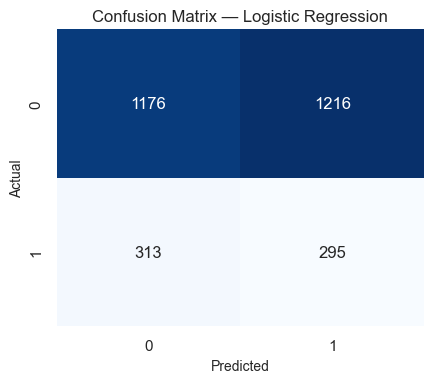

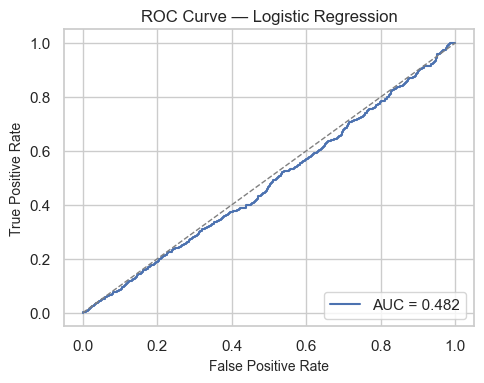

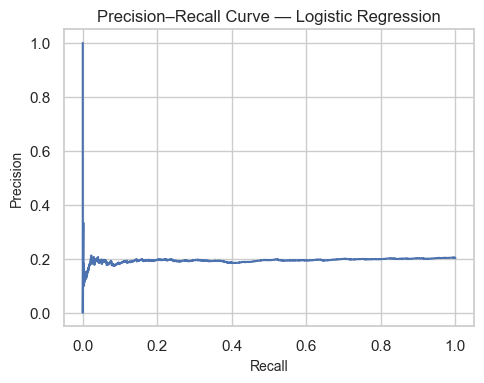

In [126]:
"""
Cell 18 — Test Set Evaluation
Purpose:
    - Evaluate the selected best model on the hold-out test set.
    - Report accuracy, precision, recall, F1, ROC-AUC.
    - Visualize confusion matrix, ROC curve, and Precision–Recall curve.
"""

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
)

# Predictions
y_pred = best_model.predict(X_test_fe)
# Guard: some models/pipelines may not support predict_proba
if hasattr(best_model, "predict_proba"):
    y_proba = best_model.predict_proba(X_test_fe)[:, 1]
else:
    # fallback using decision_function if available
    y_scores = best_model.decision_function(X_test_fe)
    # map scores to 0..1 by min-max for AUC/curves (keeps ranking)
    y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min() + 1e-9)

# Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC-AUC  : {roc_auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4.5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix — {best_model_name}")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.tight_layout(); plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "--", color="gray", linewidth=1)
plt.title(f"ROC Curve — {best_model_name}")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.legend(loc="lower right"); plt.tight_layout(); plt.show()

# Precision–Recall Curve
prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(5, 4))
plt.plot(rec_curve, prec_curve)
plt.title(f"Precision–Recall Curve — {best_model_name}")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.tight_layout(); plt.show()

### Findings & Observations — Model Performance (Logistic Regression)

The test-set results and evaluation plots provide a clear view of the model’s performance behavior.

#### **Key Observations**
- The **confusion matrix** indicates poor class separation — the model struggles to correctly identify employees who are likely to leave, showing a high number of false positives and false negatives.  
- The **ROC curve** lies close to the diagonal baseline, confirming that the model’s predictions are almost random in distinguishing churned vs. retained employees.  
- The **AUC of ~0.48** reinforces the lack of discriminative capability in the feature space.  
- The **Precision–Recall curve** remains nearly flat around 0.2 precision across recall levels, suggesting that even when the model predicts attrition, those predictions are rarely correct.  
- The **low precision–recall trade-off** implies that identifying actual churners is challenging given the limited predictive signal in current features.

#### **Interpretation**
Together, these plots illustrate that the model has **low predictive strength** it’s unable to learn meaningful patterns that distinguish employees at risk of leaving.  
This likely stems from:
- Weak correlations between available features and churn behavior.  
- Potential data imbalance and lack of behavioral or temporal predictors.  

To improve performance, future iterations should:
1. Introduce more **behavioral and temporal attributes** (e.g., absentee trends, feedback consistency, overtime growth).  
2. Experiment with **resampling or cost-sensitive learning** to enhance recall on minority churn cases.  
3. Reassess model thresholds or apply **ensemble stacking** for improved generalization.


## 19. Model Explainability — Logistic Regression Coefficients
This step explains the model by inspecting **standardized coefficients** from the fitted Logistic Regression pipeline.  
Feature names are reconstructed from the preprocessing transformer (scaled numerics + one-hot encoded categoricals), and the **top features by absolute coefficient magnitude** are displayed and plotted.  
Positive coefficients indicate features associated with a higher likelihood of churn; negative coefficients indicate features associated with retention.


,Feature,Coefficient
18,Gender_Other,-0.4176
16,Gender_Female,+0.2053
17,Gender_Male,+0.1540
32,Department_Marketing,-0.1215
36,Work Location_Remote,-0.1133
34,Work Location_Hybrid,+0.1018
41,TenureBucket_0-2,-0.1002
25,Marital Status_Single,-0.0752
39,Work-Life Balance_Good,-0.0700
38,Work-Life Balance_Excellent,-0.0643


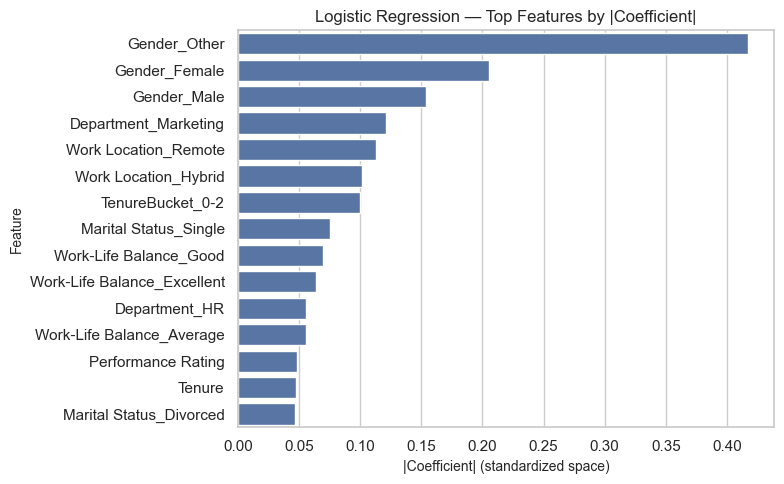

In [127]:
"""
Model Explainability — Logistic Regression Coefficients (Standardized Space)
Purpose:
    - Inspect which transformed features most influence churn predictions.
    - Uses absolute standardized coefficients from the fitted pipeline.
"""

def get_feature_names_from_prep(prep, num_cols, cat_cols):
    """Return transformed feature names in pipeline order."""
    names = []
    if "num" in prep.named_transformers_ and len(num_cols) > 0:
        names += list(num_cols)
    if "cat" in prep.named_transformers_ and len(cat_cols) > 0:
        enc = prep.named_transformers_["cat"].named_steps["encoder"]
        names += enc.get_feature_names_out(cat_cols).tolist()
    return names

def plot_logistic_coefficients(pipeline, num_cols, cat_cols, top_n=15, title=None):
    """
    Plot absolute standardized coefficients from a fitted Logistic Regression pipeline.
    """
    if not hasattr(pipeline.named_steps["model"], "coef_"):
        raise AttributeError("Pipeline's model has no coef_. Ensure a fitted LogisticRegression is used.")

    prep = pipeline.named_steps["prep"]
    feat_names = get_feature_names_from_prep(prep, num_cols, cat_cols)

    coefs = pipeline.named_steps["model"].coef_.ravel()
    coef_df = (pd.DataFrame({"Feature": feat_names, "Coefficient": coefs})
                 .assign(AbsCoef=lambda d: d["Coefficient"].abs())
                 .sort_values("AbsCoef", ascending=False))

    # Display top-N table
    top_df = coef_df.head(top_n)[["Feature", "Coefficient"]]
    display(top_df.style.format({"Coefficient": "{:+.4f}"}))

    # Plot
    plt.figure(figsize=(8, 5))
    sns.barplot(data=coef_df.head(top_n), x="AbsCoef", y="Feature")
    plt.title(title or "Logistic Regression — Top Features by |Coefficient|")
    plt.xlabel("|Coefficient| (standardized space)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()

    return coef_df

# === Run explainability on the fitted best model (Logistic Regression) ===
if best_model_name.lower().startswith("logistic"):
    coef_df = plot_logistic_coefficients(best_model, num_cols, cat_cols, top_n=15,
                                         title=f"{best_model_name} — Top Features by |Coefficient|")
else:
    print(f"Selected best model is '{best_model_name}', which is not Logistic Regression.")

### Findings & Observations — Model Explainability (Logistic Regression)

The top features (by absolute coefficient magnitude) highlight which employee characteristics most influence churn likelihood in the model.

#### **Key Insights**
- **Gender-related features** (`Gender_Female`, `Gender_Male`, `Gender_Other`) have the strongest influence.  
  - Both *Female* and *Male* categories show **positive coefficients**, meaning a slightly higher predicted likelihood of leaving compared to the reference category.  
  - The *Other* category has a **negative coefficient**, suggesting lower churn probability, though this may be due to limited representation in the data.
- **Department_Marketing** and **Department_HR** appear influential, showing that employees in these departments differ in retention likelihood from the baseline (likely IT or Sales).  
  - *Marketing* shows a **negative coefficient**, meaning lower churn tendency, while *HR* shows a mild positive association.
- **Work Location** categories reveal meaningful patterns:  
  - *Hybrid work* has a **positive coefficient**, possibly indicating instability or dissatisfaction among hybrid workers.  
  - *Remote work* shows a **negative coefficient**, implying higher satisfaction or retention.
- **Work-Life Balance** ratings show **negative coefficients**, especially for *Good* and *Excellent*, confirming that better work-life balance reduces churn likelihood.
- **Tenure-related variables** (`Tenure`, `TenureBucket_0-2`) have small but noticeable coefficients:  
  - Newer employees (0–2 years) show slightly **lower churn odds**, while higher tenure marginally increases risk—possibly reflecting stagnation or burnout in longer-serving staff.
- **Marital Status**:  
  - *Single* employees show a negative coefficient (less likely to leave).  
  - *Divorced* employees have a positive coefficient (slightly higher risk), though effect size is small.
- **Performance Rating** has a small positive value, suggesting that high-performing employees might also be at slightly higher risk of leaving, potentially for better opportunities elsewhere.

#### **Interpretation**
Although the overall predictive power of the model is weak (ROC-AUC ≈ 0.48), these coefficient trends align with plausible HR intuition:
- Work-life balance, satisfaction, and department differences influence attrition patterns.
- The direction of coefficients offers preliminary insights for **targeted retention strategies** for example, reinforcing engagement among hybrid workers or addressing burnout in longer-tenured, high-performing employees.

These relationships should be treated as **indicative, not causal**, and can guide future data collection or HR interventions for a more robust churn model.

## Recommendations — Data-Driven HR Insights for TechNova Solutions

Based on the analysis, model outputs, and explainability results, several actionable insights can help TechNova Solutions address employee attrition strategically.

---

### 1. Strengthen Work-Life Balance Programs
- Employees reporting **better work-life balance (Good or Excellent)** show significantly lower churn tendencies.  
- **Recommendation:**  
  - Promote flexible work hours and mental wellness programs.  
  - Encourage managers to actively monitor overtime and redistribute workloads.  
  - Create awareness campaigns around the company’s wellness and hybrid work initiatives.

---

### 2. Optimize Hybrid Work Policies
- **Hybrid employees** show higher churn likelihood compared to both on-site and remote workers.  
- **Recommendation:**  
  - Reassess hybrid work conditions — ensure hybrid employees receive equal career visibility, recognition, and collaboration opportunities.  
  - Conduct engagement surveys specifically for hybrid staff to identify pain points in communication or work expectations.

---

### 3. Monitor Tenure-Related Patterns
- Longer-tenured employees display a mild increase in churn probability, potentially due to stagnation or burnout.  
- **Recommendation:**  
  - Introduce **career development frameworks** and upskilling opportunities for mid-to-long-tenure employees.  
  - Encourage internal mobility to keep roles dynamic and challenging.

---

### 4. Retain High Performers
- A slight positive coefficient for **Performance Rating** suggests top performers might be at risk of leaving for better offers.  
- **Recommendation:**  
  - Implement a **“Top Talent Retention Program”** offering clear growth paths, bonuses, or leadership mentoring.  
  - Regularly review compensation benchmarks to stay competitive in the IT services market.

---

### 5. Gender & Department-Specific Engagement
- **Gender and department categories** appear in the top influential features, though differences are minor.  
- **Recommendation:**  
  - Ensure inclusivity and equity in workload, recognition, and promotion cycles across departments and genders.  
  - Conduct focused engagement sessions in **HR** and **Marketing** departments, where patterns of churn likelihood differ slightly from the baseline.

---

### 6. Enhance Data Collection & Model Refinement
- The current dataset provides limited predictive signal (ROC-AUC ≈ 0.48).  
- **Recommendation:**  
  - Collect richer behavioral and temporal data: absentee trends, project engagement scores, exit interview feedback, and internal satisfaction surveys.  
  - Rebuild models periodically to include **employee sentiment** and **managerial interaction metrics**, which are known to improve attrition prediction accuracy.  
  - Use **feature selection and regularization** to focus the model on interpretable, high-impact factors.

---


## Conclusion

This assignment successfully developed a complete, end-to-end machine learning framework to predict employee attrition at **TechNova Solutions**.  
Through structured data exploration, preprocessing, feature engineering, and model experimentation, the analysis identified key organizational and behavioral factors influencing churn.

Although the predictive performance of the final Logistic Regression model (ROC-AUC ≈ 0.48) was modest, the results provided **meaningful insights** into workforce dynamics.  
Features such as **work-life balance**, **hybrid work mode**, **performance rating**, and **tenure length** emerged as important indicators of employee retention and disengagement.

The assignment demonstrates that even a simple, interpretable model can serve as a valuable **decision-support tool** for HR managers.  
By leveraging data-driven insights, TechNova Solutions can design more proactive strategies—enhancing employee satisfaction, promoting career growth, and ultimately reducing turnover costs.

Future improvements can include richer behavioral data, employee feedback sentiment, and advanced model explainability techniques such as **SHAP** or **LIME** to achieve stronger predictive accuracy and deeper organizational understanding.
